In [1]:
import sys
import os
import datetime
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import time
import pyarrow.parquet as pq
import pyarrow as pa
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [3]:
LOCAL_DATA_PATH = './context_data/'
SPLIT_SEED = 42
DATA_FILE = 'competition_data_final_pqt'
TARGET_FILE = 'public_train.pqt'
SUBMISSION_FILE = 'submit.pqt'

In [4]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()

In [5]:
# pqf = pq.ParquetFile(f'{LOCAL_DATA_PATH}/{DATA_FILE}')
pqd = pq.ParquetDataset(f'{LOCAL_DATA_PATH}/{DATA_FILE}')
pqd.files

['./context_data//competition_data_final_pqt/part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00001-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00002-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00003-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00004-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00005-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00006-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00007-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00008-aba60f69-2b63-4cc1-95ca-

In [6]:
data_agg = None
for ifile in pqd.files :

    #data = pq.read_table(f'{LOCAL_DATA_PATH}/{DATA_FILE}/{ifile}')
    data = pq.read_table(f'{ifile}')
    #pd.DataFrame([(z.name, z.type) for z in data.schema], columns = [['field', 'type']])
    
    price_median = np.nanmedian(data.select(['price']).to_pandas().to_numpy())
    #print(price_median)

    data_agg0 = data.select(['user_id', 'url_host', 'request_cnt']).\
        group_by(['user_id', 'url_host']).aggregate([('request_cnt', "sum"),
                                                     ('request_cnt', "min"),
                                                     ('request_cnt', "max"),
                                                     ('request_cnt', "stddev"),
                                                     ('request_cnt', "mean"),])
    
    data_agg1 = data.select(['user_id','date', 'part_of_day', 'request_cnt']).\
        group_by(['user_id', 'date', 'part_of_day']).aggregate([('request_cnt', "sum"),
                                                                ('request_cnt', "min"),
                                                                ('request_cnt', "max"),
                                                                ('request_cnt', "stddev"),
                                                                ('request_cnt', "mean")])
    
    data_agg2 = data.select(['user_id', 'city_name', 'region_name', 'cpe_model_os_type', 'price','request_cnt', \
                            'cpe_manufacturer_name','cpe_model_name','cpe_type_cd']).\
        group_by(['user_id', ]).\
        aggregate([('cpe_model_os_type', "max"), ('cpe_manufacturer_name','max'),\
                   ('cpe_model_name','max'),('cpe_type_cd','max'), \
                   ('price', "max"), ('city_name', "max"), \
                   ('region_name', "max"), \
                   ('request_cnt',"mean"), \
                   ('request_cnt', "min"), \
                   ('request_cnt', "max"), \
                   ('request_cnt', "stddev"), \
                   ('request_cnt',"sum")])
    
    data_agg0 = data_agg0.to_pandas()
    data_agg1 = data_agg1.to_pandas()
    data_agg2 = data_agg2.to_pandas()
    
    data_agg2[['price_max']] = data_agg2[['price_max']].fillna(price_median)
    
    data_agg2["cpe_manufacturer_name_max"].replace( "Huawei Device Company Limited", "Huawei", inplace=True )
    data_agg2["cpe_model_os_type_max"].replace( "Apple iOS", "iOS", inplace=True ) 

    if data_agg is None :
        data_agg  = data_agg0
        data_aggB = data_agg1
        data_aggZ = data_agg2
        print(data.to_pandas().head())
    else :
        data_agg  = pd.concat([data_agg, data_agg0],ignore_index=True)
        data_aggB = pd.concat([data_aggB,data_agg1],ignore_index=True)
        data_aggZ = pd.concat([data_aggZ,data_agg2],ignore_index=True)
    
    del data, data_agg0, data_agg1, data_agg2
    
data_aggZ = data_aggZ.fillna(0)

mmm, sss = data_agg.request_cnt_sum.mean(), data_agg.request_cnt_sum.std()
data_agg.request_cnt_sum = data_agg.request_cnt_sum.clip(mmm-5*sss,mmm+5*sss)

mmm, sss = data_aggB.request_cnt_sum.mean(), data_aggB.request_cnt_sum.std()
data_aggB.request_cnt_sum = data_aggB.request_cnt_sum.clip(mmm-5*sss,mmm+5*sss)

mmm, sss = data_aggZ.request_cnt_sum.mean(), data_aggZ.request_cnt_sum.std()
data_aggZ.request_cnt_sum = data_aggZ.request_cnt_sum.clip(mmm-5*sss,mmm+5*sss)

          region_name  city_name cpe_manufacturer_name cpe_model_name  \
0  Краснодарский край  Краснодар                 Apple       iPhone 7   
1  Краснодарский край  Краснодар                 Apple       iPhone 7   
2  Краснодарский край  Краснодар                 Apple       iPhone 7   
3  Краснодарский край  Краснодар                 Apple       iPhone 7   
4  Краснодарский край  Краснодар                 Apple       iPhone 7   

                      url_host cpe_type_cd cpe_model_os_type    price  \
0                ad.adriver.ru  smartphone               iOS  20368.0   
1                    apple.com  smartphone               iOS  20368.0   
2       avatars.mds.yandex.net  smartphone               iOS  20368.0   
3  googleads.g.doubleclick.net  smartphone               iOS  20368.0   
4  googleads.g.doubleclick.net  smartphone               iOS  20368.0   

         date part_of_day  request_cnt  user_id  
0  2022-06-15     morning            1    45098  
1  2022-06-19     morn

Регион   
, населенный пункт   
, производиель устройства   
, модель устроства   
, домен, с которого пришел рекламный запрос   
, тип устройства (смартфон или что-то другое)   
, операционка на устройстве   
, оценка цены устройства   
, дата   
, время дня (утро, вечер ...)   
, число запросов   
, id пользователя   

In [7]:
data_agg.info(), data_aggB.info(), data_aggZ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32277669 entries, 0 to 32277668
Data columns (total 7 columns):
 #   Column              Dtype  
---  ------              -----  
 0   request_cnt_sum     float64
 1   request_cnt_min     int64  
 2   request_cnt_max     int64  
 3   request_cnt_stddev  float64
 4   request_cnt_mean    float64
 5   user_id             int64  
 6   url_host            object 
dtypes: float64(3), int64(3), object(1)
memory usage: 1.7+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37097238 entries, 0 to 37097237
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   request_cnt_sum     float64
 1   request_cnt_min     int64  
 2   request_cnt_max     int64  
 3   request_cnt_stddev  float64
 4   request_cnt_mean    float64
 5   user_id             int64  
 6   date                object 
 7   part_of_day         object 
dtypes: float64(3), int64(3), object(2)
memory usage: 2.2+ GB
<class 'pandas.core.f

(None, None, None)

In [8]:
data_agg.columns, data_aggB.columns, data_aggZ.columns

(Index(['request_cnt_sum', 'request_cnt_min', 'request_cnt_max',
        'request_cnt_stddev', 'request_cnt_mean', 'user_id', 'url_host'],
       dtype='object'),
 Index(['request_cnt_sum', 'request_cnt_min', 'request_cnt_max',
        'request_cnt_stddev', 'request_cnt_mean', 'user_id', 'date',
        'part_of_day'],
       dtype='object'),
 Index(['cpe_model_os_type_max', 'cpe_manufacturer_name_max',
        'cpe_model_name_max', 'cpe_type_cd_max', 'price_max', 'city_name_max',
        'region_name_max', 'request_cnt_mean', 'request_cnt_min',
        'request_cnt_max', 'request_cnt_stddev', 'request_cnt_sum', 'user_id'],
       dtype='object'))

In [9]:
n_urls = 450 #500

urls_hosts_max=data_agg[['url_host','user_id']].groupby(['url_host']).size().reset_index()
                #sort_values('user_id', axis=0, ascending=False)[:10].reset_index()
urls_hosts_max.columns = ['url_host','size']
url_hosts_max = urls_hosts_max.sort_values('size', ascending=False).head(n_urls).url_host
#url_hosts_max.to_list()

In [10]:
data_temp = data_agg[~data_agg['url_host'].isin(url_hosts_max.to_list())]
data_aggY = pd.concat([data_temp, \
      data_agg[data_agg['user_id']. \
               isin(list(set(data_agg.user_id.unique())-set(data_temp.user_id.unique())))]], \
      ignore_index=True)
data_aggY.shape, data_aggY.head()

((8799676, 7),
    request_cnt_sum  request_cnt_min  request_cnt_max  request_cnt_stddev  \
 0              2.0                1                1                 0.0   
 1              1.0                1                1                 0.0   
 2              1.0                1                1                 0.0   
 3              1.0                1                1                 0.0   
 4              1.0                1                1                 0.0   
 
    request_cnt_mean  user_id             url_host  
 0               1.0    45098          bravisan.ru  
 1               1.0    45098           festima.ru  
 2               1.0    45098       onlinetours.ru  
 3               1.0    45098  forum.skoda-club.ru  
 4               1.0    45098             mamba.ru  )

In [11]:
data_agg.shape, data_aggY.shape, len(data_agg['user_id'].unique()), len(data_aggZ.user_id.unique())

((32277669, 7), (8799676, 7), 415317, 415317)

In [12]:
if 1 :
    
    data_aggC = data_aggZ[['user_id','cpe_model_os_type_max', 'cpe_manufacturer_name_max', \
                           'cpe_model_name_max', 'cpe_type_cd_max', \
                           'region_name_max','city_name_max','price_max']]
    
    cat_features  = ['cpe_model_os_type_max', 'cpe_manufacturer_name_max', \
                     'cpe_model_name_max', 'cpe_type_cd_max', \
                     'region_name_max','city_name_max',]
    
    
    
    data_aggD = pd.pivot_table(data_aggB[['user_id','part_of_day','request_cnt_sum']],
                                index='user_id', columns='part_of_day', values='request_cnt_sum', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])
    
    data_aggD = pd.pivot_table(data_aggB[['user_id','part_of_day','request_cnt_max']],
                                index='user_id', columns='part_of_day', values='request_cnt_max', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'], suffixes=('','_xmax'))
    
    data_aggD = pd.pivot_table(data_aggB[['user_id','part_of_day','request_cnt_min']],
                                index='user_id', columns='part_of_day', values='request_cnt_min', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'], suffixes=('','_xmin'))

    data_aggD = pd.pivot_table(data_aggB[['user_id','part_of_day','request_cnt_mean']],
                                index='user_id', columns='part_of_day', values='request_cnt_mean', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'], suffixes=('','_xmean'))
    
    
    data_aggD = pd.pivot_table(data_aggB[['user_id','part_of_day','request_cnt_stddev']],
                                index='user_id', columns='part_of_day', values='request_cnt_stddev', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'], suffixes=('','_xstd'))
    
    
    
    data_aggB['DW'] = 'DW' + pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str)
    data_aggD = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_sum']],
                                index='user_id', columns='DW', values='request_cnt_sum',
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'], suffixes=('','_xxsum'))

    data_aggB['DW'] = 'DW' + pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str)
    data_aggD = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_max']],
                                index='user_id', columns='DW', values='request_cnt_max',
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'], suffixes=('','_xxmax'))

    data_aggB['DWMIN'] = 'DW' + pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str)
    data_aggD = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_min']],
                                index='user_id', columns='DW', values='request_cnt_min',
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'], suffixes=('','_xxmin'))

    data_aggB['DW'] = 'DW' + pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str)
    data_aggD = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_stddev']],
                                index='user_id', columns='DW', values='request_cnt_stddev',
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'], suffixes=('','_xxstd'))

    
    
    data_aggB['DW'] = 'DWPD'+pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str)+'.'+data_aggB.part_of_day
    data_aggD = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_sum']],
                                index='user_id', columns='DW', values='request_cnt_sum', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'], suffixes=('','_xsumpd'))

    data_aggB['DW'] = 'DWPD'+pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str)+'.'+data_aggB.part_of_day
    data_aggD = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_mean']],
                                index='user_id', columns='DW', values='request_cnt_mean', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'], suffixes=('','_xmeanpd'))

    data_aggB['DW'] = 'DWPD'+pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str)+'.'+data_aggB.part_of_day
    data_aggD = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_max']],
                                index='user_id', columns='DW', values='request_cnt_max', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'], suffixes=('','_xmaxpd'))

    data_aggB['DW'] = 'DWPD'+pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str)+'.'+data_aggB.part_of_day
    data_aggD = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_stddev']],
                                index='user_id', columns='DW', values='request_cnt_stddev', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'], suffixes=('','_xstdpd'))
    

In [13]:
#
#  tf-idf
#
def tf_idf (data_agg) :
    
    #data_a = data_agg[['user_id','url_host']].groupby(['user_id']).size().reset_index()
    data_a = data_agg[['user_id','request_cnt_sum',]].groupby('user_id').sum().reset_index()
    data_a.columns=['user_id','summ']
    data_tf = data_agg.merge(data_a, how='left', on='user_id')
    data_tf['tf'] = data_tf.request_cnt_sum/data_tf.summ
    data_tf       = data_tf[['user_id','url_host','tf']]
    
    if 0 :
        print('tf')
        print(data_a.shape, data_tf.shape, data_aggY.shape)
        print(data_a.head())
        print(data_tf.head())
    
    data_a = data_agg[['url_host','user_id',]].groupby('url_host').size().reset_index()
    data_a.columns=['url_host','sizee']
    user_id_len = len(data_agg.user_id.unique())
    
    data_idf = data_a
    data_idf['idf'] = np.log(user_id_len/data_a.sizee)
    
    if 0 :
        print('idf')
        print(data_a.shape, data_idf.shape, data_agg.shape)
        print(data_a.head())
        print(data_idf.head())
    
    data_tf_idf = data_tf.merge(data_idf[['url_host','idf']], how='left', on='url_host')
    data_tf_idf['tf_idf'] = data_tf_idf.tf*data_tf_idf.idf
    
    if 0 :
        print('idf')
        print(data_tf_idf.shape)
        print(data_tf_idf.head())
    
    return (data_tf_idf)
    
data_tf_idf  = tf_idf(data_agg)    
data_tf_idfY = tf_idf(data_aggY)    

print(data_tf_idf.shape, data_tf_idfY.shape)

(32277669, 5) (8799676, 5)


In [14]:
data_aggC.shape, data_aggC.columns

((415317, 168),
 Index(['user_id', 'cpe_model_os_type_max', 'cpe_manufacturer_name_max',
        'cpe_model_name_max', 'cpe_type_cd_max', 'region_name_max',
        'city_name_max', 'price_max', 'day', 'evening',
        ...
        'DWPD4.morning_xstdpd', 'DWPD4.night_xstdpd', 'DWPD5.day_xstdpd',
        'DWPD5.evening_xstdpd', 'DWPD5.morning_xstdpd', 'DWPD5.night_xstdpd',
        'DWPD6.day_xstdpd', 'DWPD6.evening_xstdpd', 'DWPD6.morning_xstdpd',
        'DWPD6.night_xstdpd'],
       dtype='object', length=168))

In [15]:

if 1 :
    data_aggC['A']=data_aggC.day+data_aggC.evening+data_aggC.morning+data_aggC.night
    data_aggC['A000']=data_aggC.day/data_aggC.A    
    data_aggC['A001']=data_aggC.evening/data_aggC.A
    data_aggC['A002']=data_aggC.morning/data_aggC.A
    data_aggC['A003']=data_aggC.night/data_aggC.A 
    
if 1 :
    B000m=data_aggC.day.mean()
    B001m=data_aggC.evening.mean()
    B002m=data_aggC.morning.mean()                
    B003m=data_aggC.night.mean()
    data_aggC['B000']=data_aggC.day/B000m
    data_aggC['B001']=data_aggC.evening/B001m
    data_aggC['B002']=data_aggC.morning/B002m
    data_aggC['B003']=data_aggC.night/B003m
    #data_aggC = data_aggC.drop(['day','morning','evening'],axis=1)
        
if 1 :
    DWA0  =data_aggC.DW0.median()
    DWA1  =data_aggC.DW1.median()
    DWA2  =data_aggC.DW2.median()
    DWA3  =data_aggC.DW3.median()
    DWA4  =data_aggC.DW4.median()
    DWA5  =data_aggC.DW5.median()
    DWA6  =data_aggC.DW6.median()
    data_aggC['DWB000']=data_aggC.DW0/DWA0
    data_aggC['DWB001']=data_aggC.DW1/DWA1 
    data_aggC['DWB002']=data_aggC.DW2/DWA2
    data_aggC['DWB003']=data_aggC.DW3/DWA3
    data_aggC['DWB004']=data_aggC.DW4/DWA4
    data_aggC['DWB005']=data_aggC.DW5/DWA5
    data_aggC['DWB006']=data_aggC.DW6/DWA6 
    
if 1 :
    data_aggC['DWA']=data_aggC.DW0+data_aggC.DW1+data_aggC.DW2+data_aggC.DW3+ \
                        data_aggC.DW4+data_aggC.DW5+data_aggC.DW6
    data_aggC['DW000']=data_aggC.DW0/data_aggC.DWA
    data_aggC['DW001']=data_aggC.DW1/data_aggC.DWA
    data_aggC['DW002']=data_aggC.DW2/data_aggC.DWA
    data_aggC['DW003']=data_aggC.DW3/data_aggC.DWA
    data_aggC['DW004']=data_aggC.DW4/data_aggC.DWA
    data_aggC['DW005']=data_aggC.DW5/data_aggC.DWA
    data_aggC['DW006']=data_aggC.DW6/data_aggC.DWA
    
data_aggC.shape, data_aggC.columns

((415317, 192),
 Index(['user_id', 'cpe_model_os_type_max', 'cpe_manufacturer_name_max',
        'cpe_model_name_max', 'cpe_type_cd_max', 'region_name_max',
        'city_name_max', 'price_max', 'day', 'evening',
        ...
        'DWB005', 'DWB006', 'DWA', 'DW000', 'DW001', 'DW002', 'DW003', 'DW004',
        'DW005', 'DW006'],
       dtype='object', length=192))

In [16]:
data_aggC.shape

(415317, 192)

In [17]:
targets = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}')
usr_targets = targets.to_pandas()

pd.DataFrame([(z.name, z.type) for z in targets.schema], columns = [['field', 'type']])

,field,type
0,age,double
1,is_male,string
2,user_id,int64
3,__index_level_0__,int64


In [18]:
import matplotlib.pyplot as plt

def plotplot (usr_targets, plot_table, xxx=['user_id']) :
    usr_targets_true  = plot_table.user_id.isin(usr_targets.user_id.values)
    plot_true  = plot_table[usr_targets_true]
    plot_false = plot_table[~usr_targets_true]
    
    for col in [xx for xx in list(plot_true.columns) if xx not in xxx] :
        plt.hist(plot_true[col],bins=50)
        plt.hist(plot_false[col],bins=50)
        plt.title(col)
        plt.show()
    
    return

#plotplot(usr_targets, data_aggC)

#plotplot(usr_targets, data_agg,  xxx=['user_id', 'url_host'])
#plotplot(usr_targets, data_aggB, xxx=['user_id', 'url_host', ])

In [19]:
usr_targets = targets.to_pandas()
usr_targets.describe()
#np.unique(usr_targets.is_male.to_numpy())
usr_targets.is_male[usr_targets.is_male=='NA'] = np.nan
np.unique(usr_targets.is_male.astype(float),return_counts=True)
#usr_targets.is_male.astype(float).describe()

(array([ 0.,  1., nan, ..., nan, nan, nan]),
 array([128994, 135332,      1, ...,      1,      1,      1]))

In [20]:
data_agg_train = data_agg.merge(usr_targets[['user_id']], 
                                how='inner', on=['user_id'])
len(data_agg_train)

21019656

In [21]:
usr_targets_true  = data_agg.user_id.isin(usr_targets.user_id.values)
data_agg[usr_targets_true]
data_agg[~usr_targets_true]

,request_cnt_sum,request_cnt_min,request_cnt_max,request_cnt_stddev,request_cnt_mean,user_id,url_host
0,12.000000,1,2,0.287480,1.090909,45098,ad.adriver.ru
1,329.382408,1,6,1.099694,1.874046,45098,apple.com
2,174.000000,1,4,0.656000,1.392000,45098,avatars.mds.yandex.net
3,305.000000,1,5,1.018156,1.732955,45098,googleads.g.doubleclick.net
4,329.382408,1,5,1.113451,1.939130,45098,i.ytimg.com
...,...,...,...,...,...,...,...
32277530,1.000000,1,1,0.000000,1.000000,260127,m-gazeta-ru.cdn.ampproject.org
32277531,1.000000,1,1,0.000000,1.000000,260127,mcgrp.ru
32277532,2.000000,2,2,0.000000,2.000000,260127,click.mail.ru
32277533,1.000000,1,1,0.000000,1.000000,260127,kakoysegodnyaprazdnik.ru


In [22]:
data_agg[~data_agg.user_id.isin(usr_targets.user_id.values)]

,request_cnt_sum,request_cnt_min,request_cnt_max,request_cnt_stddev,request_cnt_mean,user_id,url_host
0,12.000000,1,2,0.287480,1.090909,45098,ad.adriver.ru
1,329.382408,1,6,1.099694,1.874046,45098,apple.com
2,174.000000,1,4,0.656000,1.392000,45098,avatars.mds.yandex.net
3,305.000000,1,5,1.018156,1.732955,45098,googleads.g.doubleclick.net
4,329.382408,1,5,1.113451,1.939130,45098,i.ytimg.com
...,...,...,...,...,...,...,...
32277530,1.000000,1,1,0.000000,1.000000,260127,m-gazeta-ru.cdn.ampproject.org
32277531,1.000000,1,1,0.000000,1.000000,260127,mcgrp.ru
32277532,2.000000,2,2,0.000000,2.000000,260127,click.mail.ru
32277533,1.000000,1,1,0.000000,1.000000,260127,kakoysegodnyaprazdnik.ru


In [23]:
import faiss

def set1 (items) :
    item_set = set(items)
    #print(f'{len(items)} items')
    item_dict = {item: iditem for item, iditem in zip(item_set, range(len(item_set)))}
    items_new = np.array(items.map(item_dict))
    return(item_dict, items_new)
    
def alsals (values, rows, cols, factors=50, iterations=30, clusters=400) :
    
    #values = np.array(data_agg['request_cnt_sum'])
    #rows   = np.array(data_agg['user_id'].map(usr_dict))
    #cols   = np.array(data_agg['url_host'].map(url_dict))
    mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
    als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = factors, iterations = iterations, \
           #use_gpu = True, nlist=clusters, \
           use_gpu = False, nlist=clusters, \
           calculate_training_loss = False, regularization = 0.1)
           #calculate_training_loss = False, regularization = 0.1)
    als.fit(mat)
    u_factors = als.model.user_factors 
    d_factors = als.model.item_factors
    
    return u_factors

def doMatrix (users, items, values, clusters=400, factors=50, iterations=30) :
    users_dict, users_new = set1(users)
    items_dict, items_new = set1(items)

    uu = alsals(values,users_new,items_new, clusters=clusters, factors=factors, iterations=iterations)
    uu = pd.DataFrame(uu)

    inv_users_dict = {v: k for k, v in users_dict.items()}
    uu['user_id'] = uu.index.map(inv_users_dict)
    return uu

In [24]:
%%time

if 1 :
    u12= doMatrix(pd.concat([#data_agg.user_id, \
                         data_agg.user_id, \
                         data_agg.user_id, \
                         data_agg.user_id, \
                         #data_agg.user_id, \
                        ], ignore_index=True),
              pd.concat([#data_agg.url_host,\
                         data_agg.url_host,\
                         data_agg.url_host,\
                         data_agg.url_host,\
                         #data_agg.url_host,\
                        ], ignore_index=True),\
              pd.concat([#data_agg.request_cnt_sum,\
                         data_agg.request_cnt_mean/np.mean(data_agg.request_cnt_mean) \
                         *np.mean(data_agg.request_cnt_sum), \
                         data_agg.request_cnt_max/np.mean(data_agg.request_cnt_max) \
                         *np.mean(data_agg.request_cnt_sum), \
                         data_agg.request_cnt_min/np.mean(data_agg.request_cnt_min) \
                         *np.mean(data_agg.request_cnt_sum), \
                         #data_agg.request_cnt_stddev/np.mean(data_agg.request_cnt_stddev) \
                         #*np.mean(data_agg.request_cnt_sum), \
                        ], ignore_index=True).fillna(0),
              #clusters=400, factors=50)
              #clusters=400, factors=350, iterations=30)     
              #clusters=400, factors=550, iterations=30)
              #clusters=400, factors=3000, iterations=30)
              #clusters=400, factors=150, iterations=30)
              clusters=400, factors=150, iterations=50)

if 1 :
    u12x1= doMatrix(pd.concat([#data_agg.user_id, \
                         #data_agg.user_id, \
                         data_tf_idf.user_id, \
                         data_tf_idf.user_id, \
                         #data_tf_idf.user_id, \
                         #data_aggB.user_id, \
                         #data_aggB.user_id, \
                        ], ignore_index=True),
              pd.concat([#data_agg.url_host,\
                         #data_agg.url_host,\
                         data_tf_idf.url_host,\
                         data_tf_idf.url_host,\
                         #data_tf_idf.url_host, \
                         #data_aggB.part_of_day, \
                         #data_aggB.part_of_day, \
                         #data_aggB.DW,
                         #data_aggB.DW,
                        ], ignore_index=True),\
              pd.concat([#data_agg.request_cnt_sum,\
                         #data_agg.request_cnt_mean/np.mean(data_agg.request_cnt_mean)* \
                         #         np.mean(data_agg.request_cnt_sum), \
                         data_tf_idf.tf_idf/np.mean(data_tf_idf.tf_idf)*np.mean(data_agg.request_cnt_sum), \
                         data_tf_idf.tf/np.mean(data_tf_idf.tf)*np.mean(data_agg.request_cnt_sum), \
                         #data_tf_idf.idf/np.mean(data_tf_idf.idf)*np.mean(data_agg.request_cnt_sum), \
                         #data_aggB.request_cnt_sum/np.mean(data_aggB.request_cnt_sum)* \
                         #  np.mean(data_agg.request_cnt_sum), \
                         #data_aggB.request_cnt_mean/np.mean(data_aggB.request_cnt_mean)* \
                         #  np.mean(data_agg.request_cnt_sum), \
                        ], ignore_index=True),
              #clusters=400, factors=50)
              #clusters=400, factors=350, iterations=30)     
              #clusters=400, factors=550, iterations=30)
              #clusters=400, factors=3000, iterations=30)
              #clusters=400, factors=150, iterations=30)
              clusters=400, factors=150, iterations=50)

if 1 :
    data_aggB['DW'] = 'DW' + pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str) + '.' + data_aggB.part_of_day
    u12x2= doMatrix(pd.concat([#data_agg.user_id, \
                         data_aggB.user_id, \
                        ], ignore_index=True),
              pd.concat([#data_agg.url_host,\
                         data_aggB.DW,
                        ], ignore_index=True),\
              pd.concat([#data_agg.request_cnt_sum,\
                         data_aggB.request_cnt_stddev/np.mean(data_aggB.request_cnt_stddev)* \
                           np.mean(data_agg.request_cnt_sum), \
                        ], ignore_index=True),
              clusters=10, factors=150, iterations=50)



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

WARNING clustering 28 points to 10 centroids: please provide at least 390 training points


CPU times: user 2h 19min 49s, sys: 2min 39s, total: 2h 22min 28s
Wall time: 20min 45s


In [25]:
u12.shape, data_aggC.shape

((415317, 151), (415317, 192))

## Получим оценку по полу

In [98]:
%%time

usr_emb = u12
usr_emb = usr_emb.merge(u12x1,     how = 'inner', on = ['user_id'], suffixes=('_x1','_x1x1'))
usr_emb = usr_emb.merge(u12x2,     how = 'inner', on = ['user_id'], suffixes=('_x1','_x1x2'))
usr_emb = usr_emb.merge(data_aggC, how = 'inner', on = ['user_id'], suffixes=('_u12','_aggC'))

cat_features  = ['cpe_model_os_type_max', 'cpe_manufacturer_name_max', \
                 'cpe_model_name_max', 'cpe_type_cd_max', \
                 'region_name_max','city_name_max',]

#usr_emb[cat_features] = usr_emb[cat_features].fillna(' ')
#usr_emb = usr_emb.fillna(-1)

usr_targets = targets.to_pandas()
df = usr_targets.merge(usr_emb,   how = 'inner', on = ['user_id'])
df = df[df['is_male'] != 'NA']
df = df.dropna()
df['is_male'] = df['is_male'].map(int)
df['is_male'].value_counts()

CPU times: user 6.13 s, sys: 1.46 s, total: 7.58 s
Wall time: 7.57 s


1    135331
0    128994
Name: is_male, dtype: int64

In [99]:
#df1 = df
#df = df.drop('price_max',axis=1)
df.shape, cat_features #,cat_feature_

((264325, 644),
 ['cpe_model_os_type_max',
  'cpe_manufacturer_name_max',
  'cpe_model_name_max',
  'cpe_type_cd_max',
  'region_name_max',
  'city_name_max'])

In [100]:
class_weights = np.unique(df['is_male'].values, return_counts=True)[1]
#class_weights[1] += class_weights[0]
#class_weights[0]  = 1
class_sum = np.sum(class_weights); class_weights, class_sum
class_weights = class_weights / class_sum * class_weights.shape[0]
class_weights, np.sum(class_weights)

(array([0.97602573, 1.02397427]), 2.0)

In [121]:
%%time
print(datetime.datetime.now())
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], 
    test_size = 0.2, stratify=df['is_male'].values, random_state = SPLIT_SEED)

#clf1 = CatBoostClassifier(iterations=3500, early_stopping_rounds=25, 
clf1 = CatBoostClassifier(early_stopping_rounds=25, 
                          cat_features=cat_features, 
                          #task_type='GPU', devices='0:1',
                          iterations=4000, max_depth=4, #learning_rate=0.017395,
                          #n_estimators=7750, max_depth=8, learning_rate=0.017395,
                          #class_weights=class_weights,
                          auto_class_weights = 'SqrtBalanced',
                          one_hot_max_size=10)

#n_estimators=7750, max_depth=8, learning_rate=0.017395
clf1.fit(x_train, y_train, verbose = False, eval_set=(x_test,y_test), 
         use_best_model=True, plot=True)
print(f'GINI по полу {2 * m.roc_auc_score(y_test, clf1.predict_proba(x_test)[:,1]) - 1:2.3f}')

2023-03-29 13:53:42.005430


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

GINI по полу 0.745
CPU times: user 50min 26s, sys: 51.8 s, total: 51min 18s
Wall time: 6min 57s


In [122]:
#clf1.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 3500,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 10,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0

In [124]:
%%time
print(datetime.datetime.now())
#clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], verbose = False)
id_to_submit['is_male'] = clf1.predict_proba(id_to_submit[['user_id']].merge(usr_emb, how = 'inner', on = ['user_id']).
                                            drop(['user_id'], axis=1))[:,1]

2023-03-29 14:02:23.393441


CatBoostError: There is no trained model to use predict_proba(). Use fit() to train model. Then use this method.

In [125]:
#plt.scatter(y_test, clf1.predict_proba(x_test)[:,1]) #,alpha=0.3,s=10*clf1.predict_proba(x_test)[:,1])
#plt.show()

#plt.hist(y_test)
#plt.hist(clf1.predict_proba(x_test)[:,1])
#plt.show()
y_proba = clf1.predict_proba(x_test)[:,1]
aarg = np.argsort(y_proba)
plt.plot(y_proba[aarg]) #,c=(250*y_test,y_test,0))
plt.plot([0,len(y_proba)],[0,1])
plt.show()

plt.hist2d(range(len(x_test)), y_proba[aarg], bins=(len(x_test),50))
plt.show()

CatBoostError: There is no trained model to use predict_proba(). Use fit() to train model. Then use this method.

0 - 20509   25799   5290
1 - 5953   27066   21113


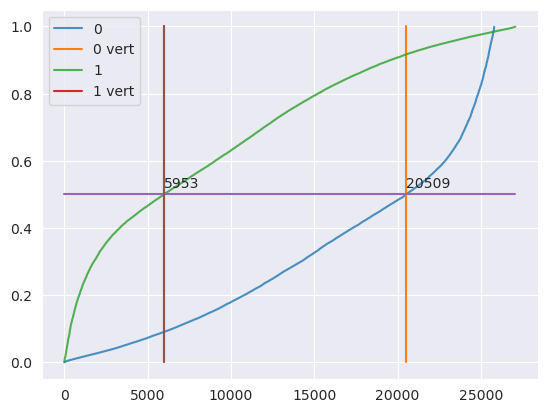

In [120]:
import matplotlib.pyplot as plt
import numpy as np

yticks  = [1, 0,]
legenda = []

for k in [0,1]:
    # Generate the random data for the y=k 'layer'.
    
    yy = y_proba[aarg][y_test.values[aarg]==k]
    
    xs = np.arange(len(yy))
    ys = yy
    
    plt.plot(ys, alpha=0.8) #, color=cs, alpha=0.8)
    
    legenda.append(k)
    
    xx = np.argwhere(yy>=0.5)[0][0]; print(k,'-',xx,' ',len(yy), ' ', len(yy)-xx)
    
    plt.plot([xx,xx],[0,1.0])
    legenda.append(str(k)+' vert')
    
    plt.text(xx, 0.52, str(xx))
    
    
plt.legend(legenda)

plt.plot([0,len(yy)],[0.5,0.5])

plt.plot([np.argwhere(yy>=0.5)[0][0],np.argwhere(yy>=0.5)[0][0]],[0,1.0])

plt.show()

## Получим оценку по возрасту

In [36]:
%%time

u20 = doMatrix(pd.concat([data_aggY.user_id, \
                         data_aggY.user_id, \
                         data_agg.user_id, \
                         data_agg.user_id, \
                         data_agg.user_id, \
                         data_tf_idfY.user_id, \
                         data_tf_idfY.user_id, \
                        ], ignore_index=True),
              pd.concat([data_aggY.url_host,\
                         data_aggY.url_host,\
                         data_agg.url_host,\
                         data_agg.url_host,\
                         data_agg.url_host,\
                         data_tf_idfY.url_host,\
                         data_tf_idfY.url_host,\
                        ], ignore_index=True),\
              pd.concat([data_aggY.request_cnt_sum,\
                         data_aggY.request_cnt_mean/np.mean(data_aggY.request_cnt_mean)* \
                                  np.mean(data_aggY.request_cnt_sum), \
                         data_agg.request_cnt_max/np.mean(data_agg.request_cnt_max)* \
                                  np.mean(data_aggY.request_cnt_sum), \
                         data_agg.request_cnt_min/np.mean(data_agg.request_cnt_min)* \
                                  np.mean(data_aggY.request_cnt_sum), \
                         data_agg.request_cnt_stddev/np.mean(data_agg.request_cnt_stddev)* \
                                  np.mean(data_aggY.request_cnt_sum), \
                         data_tf_idfY.tf_idf/np.mean(data_tf_idfY.tf_idf)*np.mean(data_aggY.request_cnt_sum), \
                         data_tf_idfY.tf/np.mean(data_tf_idfY.tf)*np.mean(data_aggY.request_cnt_sum), \
                        ], ignore_index=True).fillna(0),
              clusters=400, factors=350, iterations=50)

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 2h 1min 7s, sys: 1min 18s, total: 2h 2min 26s
Wall time: 16min 53s


In [90]:
u20.shape

(415317, 351)

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline
sns.set_style('darkgrid')

In [92]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

(415317, 542) (269957, 544)


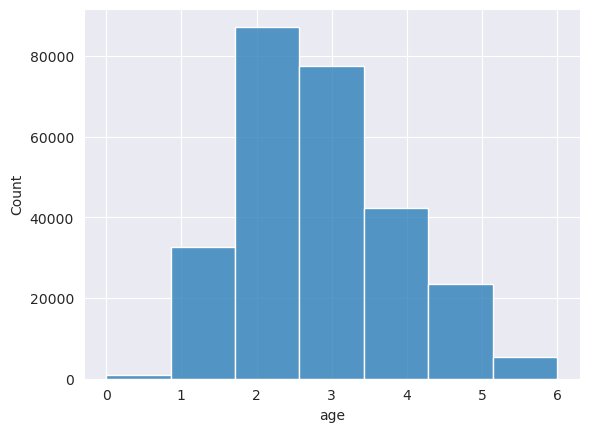

In [126]:
usr_embx2 = u20
usr_embx2 = usr_embx2.merge(data_aggC, how = 'inner', on = ['user_id'], suffixes=('_u12','_aggC'))

df = usr_targets.merge(usr_embx2, how = 'inner', on = ['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins = 7)
print(usr_embx2.shape,df.shape)

In [94]:
class_weights = np.unique(df['age'].values, return_counts=True)[1]
#class_weights[1] += class_weights[0]
#class_weights[0]  = 1
class_sum = np.sum(class_weights); class_weights, class_sum
class_weights = class_weights / class_sum * class_weights.shape[0]
class_weights, np.sum(class_weights)

(array([0.02683761, 0.84638294, 2.26291595, 2.00921628, 1.10052342,
        0.61143071, 0.1426931 ]),
 7.0)

In [ ]:
%%time
print(datetime.datetime.now())
x_train, x_test, y_train, y_test = train_test_split(\
    #df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], test_size = 0.33, random_state = SPLIT_SEED)
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], 
    test_size = 0.1, stratify=df['age'].values, random_state = SPLIT_SEED)

#clf = CatBoostClassifier(iterations=3500, early_stopping_rounds=25, one_hot_max_size=10, cat_features=cat_features)
clf = CatBoostClassifier(early_stopping_rounds=25, 
                          cat_features=cat_features, 
                          #task_type='GPU', devices='0:1',
                          iterations=3500, max_depth=4, #learning_rate=0.017395,
                          #n_estimators=7750, max_depth=8, learning_rate=0.017395,
                          #class_weights=class_weights,
                          auto_class_weights = 'SqrtBalanced',
                          one_hot_max_size=10)

#clf.fit(x_train, y_train, verbose = False)
clf.fit(x_train, y_train, verbose = False, eval_set=(x_test,y_test), use_best_model=True,plot=True)
print(m.classification_report(y_test, clf.predict(x_test), \
                            target_names = ['<18', '18-25','25-34', '35-44', '45-54', '55-65', '65+']))

2023-03-29 14:03:20.204554


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [38]:
f1 0.01 0.38 0.55 0.44 0.27 0.27 0.03 - 0.44 0.28 0.41 (1.3164)
f1 0.00 0.39 0.55 0.44 0.27 0.27 0.04 - 0.44 0.28 0.42 (1.3110) (2*aggY    + tf)
f1 0.00 0.35 0.53 0.43 0.25 0.26 0.02 - 0.42 0.26 0.40 (1.3396) (aggY+agg  + tf + idf)
f1 0.00 0.38 0.54 0.44 0.27 0.27 0.03 - 0.44 0.28 0.41 (1.3145) (aggY+aggY + tf + idf) -400urls
f1 0.01 0.39 0.55 0.45 0.27 0.27 0.03 - 0.44 0.28 0.42 (1.3078) (aggY+aggY + tf + idf) -600urls
f1 0.00 0.40 0.55 0.45 0.27 0.28 0.04 - 0.44 0.28 0.42 (1.3073) (aggY+aggY + tf + idf) -500urls
f1 0.01 0.40 0.55 0.45 0.27 0.28 0.02 - 0.44 0.28 0.42 (1.3068) (aggY+aggY + tf + idf) -450urls

f1 0.01 0.41 0.56 0.46 0.28 0.30 0.04 - 0.45 0.29 0.43 (1.2834(1901)) (aggY+aggY + tf + idf) -450urls + aggC
f1 0.02 0.42 0.56 0.47 0.30 0.30 0.03 - 0.46 0.30 0.44 (1.2750(2072)) (aggY+aggY+tf+idf) -450urls +aggC (250.30)
f1 0.01 0.42 0.57 0.46 0.30 0.31 0.04 - 0.46 0.30 0.44 (1.2754(2325)) 

f1 0.01 0.41 0.56 0.46 0.30 0.29 0.02 - 0.46 0.29 0.44 (1.2738(2325)) 



f1 0.01 0.42 0.56 0.47 0.30 0.30 0.04 - 0.46 0.30 0.44 (als = 250.30 without)
pr 0.25 0.53 0.50 0.42 0.39 0.41 0.41 - -    0.42 0.45
re 0.01 0.34 0.64 0.52 0.24 0.24 0.02 - -    0.29 0.46

SyntaxError: invalid syntax (2154498432.py, line 1)

In [72]:
clf.get_all_params()

(269957, 544)

In [73]:
%%time
print(datetime.datetime.now())
#clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], verbose = False)
id_to_submit['age'] = clf.predict(id_to_submit[['user_id']].merge(usr_embx2, how = 'inner', on = ['user_id']).
                                                            drop(['user_id'], axis=1))

2023-03-29 05:45:57.543215
CPU times: user 5.8 s, sys: 408 ms, total: 6.21 s
Wall time: 1.95 s


In [74]:
df.shape

(269957, 544)

## Сабмит

In [87]:
id_to_submit.head()

,user_id,is_male,age
221301,221301,0.961713,2
31271,31271,0.518083,3
211594,211594,0.622261,2
253119,253119,0.618155,2
192578,192578,0.863694,2


In [88]:
id_to_submit.to_csv(f'{LOCAL_DATA_PATH}/submission50.csv', index = False)

In [89]:
! head $LOCAL_DATA_PATH/submission50.csv

user_id,is_male,age
221301,0.9617133212451425,2
31271,0.5180827206583365,3
211594,0.6222605351221602,2
253119,0.618155160251199,2
192578,0.8636937882198331,2
268458,0.3605085403907382,2
205507,0.5220870447310679,2
341343,0.5706151997158829,3
282144,0.05741027781332833,2


# Скор на лидерборде

In [187]:
#context_scorer(submission, answers)

In [46]:
xx=clf1.get_feature_importance(prettified=True)
xx.head(50)

,Feature Id,Importances
0,69_x1x1,2.217260
1,125_x1x1,2.150286
2,58_x1x1,1.944976
3,83_x1x1,1.866809
4,109_x1,1.662825
5,131_x1x1,1.608032
6,27_x1x1,1.303951
7,149_x1,1.264852
8,73_x1x1,1.251687
9,88_x1x1,1.177450


In [47]:
xx=clf.get_feature_importance(prettified=True)
xx.head(50)

,Feature Id,Importances
0,cpe_model_name_max,1.505491
1,336,0.944703
2,121,0.907715
3,price_max,0.828331
4,284,0.806262
5,204,0.765496
6,248,0.701574
7,347,0.681361
8,293,0.673303
9,228,0.669532


In [279]:
np.save('./u12-250.npy',u12)
np.save('./u12x2-250.npy',u12x2)

In [62]:
nnsubs = pd.read_csv(f'{LOCAL_DATA_PATH}/submission23.csv')

In [63]:
nnsubs.age = nnsubs.age+1
nnsubs.age = nnsubs.age.clip(1,6)

In [59]:
np.unique(nnsubs.age,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([    1, 10141, 60888, 53972, 13155,  6435,   132]))

In [64]:
np.unique(nnsubs.age,return_counts=True)

(array([1, 2, 3, 4, 5, 6]), array([    1, 10141, 60888, 53972, 13155,  6567]))

In [51]:
nnsubs.to_csv(f'{LOCAL_DATA_PATH}/submission23b.csv', index = False)

In [69]:
print(m.classification_report(y_test, clf.predict(x_test), \
                            target_names = ['<18', '18-25','25-34', '35-44', '45-54', '55-65', '65+']))

              precision    recall  f1-score   support

         <18       0.00      0.00      0.00       167
       18-25       0.54      0.32      0.40      4804
       25-34       0.49      0.64      0.56     13048
       35-44       0.41      0.52      0.46     11746
       45-54       0.38      0.21      0.27      6362
       55-65       0.40      0.20      0.27      3523
         65+       0.48      0.02      0.04       844

    accuracy                           0.45     40494
   macro avg       0.39      0.28      0.29     40494
weighted avg       0.44      0.45      0.43     40494



In [85]:
print(m.classification_report(y_test, (clf.predict(x_test)).clip(1,6), \
                            target_names = ['<18', '18-25','25-34', '35-44', '45-54', '55-65', '65+']))

              precision    recall  f1-score   support

         <18       0.00      0.00      0.00       167
       18-25       0.54      0.32      0.40      4804
       25-34       0.49      0.64      0.56     13048
       35-44       0.41      0.52      0.46     11746
       45-54       0.38      0.21      0.27      6362
       55-65       0.40      0.20      0.27      3523
         65+       0.48      0.02      0.04       844

    accuracy                           0.45     40494
   macro avg       0.39      0.28      0.29     40494
weighted avg       0.44      0.45      0.43     40494

